# The backward pass (in practice)

In the previous chapter, we have learned about backpropagation; now, it's time to implement it. We'll continue where we left off with our `Scalar` class. To make it suitable for backpropagation, we need to make some enhancements:

1. have `Scalar`s track the backward derivatives,
2. and store the local derivatives along the incoming edges.

The first one is already there via the `Scalar.backwards_grad` attribute. As its value is calculated, we do not allow setting it upon initialization, but set it to zero instead. (I have named it `backwards_grad` instead of `backwards_derivative` to match the interface of our future `Tensor` class. I know, I am a bit of an overthinker.)

Now, onto the meaty parts!

## Tracking the local derivatives

In the {ref}`current version of Scalars <section:scalar/forward-pass>`, we only track the previous nodes. Recall how it behaves in action. (Here's the current implementation as well, if you want to recall. You have to open it manually although; I don't want to clutter the text with it.)

In [37]:
from typing import List


class Scalar:
    def __init__(self, value: float, prevs: List = None):
        self.value = value
        self.prevs = prevs if prevs is not None else []
        self.backwards_grad = 0

    def __repr__(self):
        return f"Scalar({self.value})"
    
    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[self, other],
        )
    
    def __mul__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value * other.value,
            prevs=[self, other],
        )

    def __truediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value / other.value,
            prevs=[self, other],
        )

    def __pow__(self, exponent):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value ** exponent.value,
            prevs=[self, exponent],
        )
    
    def __neg__(self):
        return (-1) * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return other / self

    def __rsub__(self, other):
        return other + (-self)

In [38]:
a = Scalar(3)
b = Scalar(4)
c = a - b

In [39]:
c.prevs

[Scalar(3), Scalar(-4)]

To carry out the backpropagation, we have to know the local derivatives along the edges. There are many possible solutions; we'll add a simple `Edge` data structure to populate `Scalar.prevs` with.

In [40]:
from collections import namedtuple


Edge = namedtuple("Edge", ["prev", "local_grad"])

`Edge` is a `namedtuple`, which is just a fancy way of implementing a simple class with the attributes `prev` and `local_grad`.

In [41]:
a = Scalar(1)
e = Edge(prev=a, local_grad=42)

In [42]:
e.prev

Scalar(1)

In [43]:
e.local_grad

42

From now on, the `Scalar.prevs` attribute will be populated with `Edge` objects. So, we have to modify the operations accordingly. For instance, let's take a look at addition function $ +(x_1, x_2) = x_1 + x_2 $. With this slightly unusual notation, the local derivatives are

$$
\frac{\partial +}{\partial x_1} = \frac{\partial +}{\partial x_2} = 1.
$$

Thus, the `Scalar` defined by `x1 + x2` will have two `Edge` objects in its `prevs` attribute: `Edge(x1, 1)` and `Edge(x2, 1)`. This is how it's done.

In [44]:
class Scalar(Scalar):
    # ...

    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[Edge(self, 1), Edge(other, 1)],
        )

    # ...    

Can you figure out the rest of the operations? Give this exercise a try. Here, let me provide a template; the rest is up to you. Implement `__mul__`, `__truediv__`, and `__pow__` so that it keeps track of all the incoming edges during the operations.

(You can use Python's `math.log` function from the built-in `math` module.)

In [45]:
import math


class Scalar(Scalar):
    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[Edge(self, 1), Edge(other, 1)],
        )

    # implement these methods along the lines of __add__:    
    def __mul__(self, other):
        pass

    def __truediv__(self, other):
        pass

    def __pow__(self, exponent):
        pass

    # auxiliary operations
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return (-1) * self

    def __rtruediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return other / self

Ready? Compare your solution to `mlfz`'s implementation:

In [46]:
class Scalar(Scalar):
    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[Edge(self, 1), Edge(other, 1)],
        )

    def __mul__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value * other.value,
            prevs=[Edge(self, other.value), Edge(other, self.value)],
        )

    def __truediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value / other.value,
            prevs=[
                Edge(self, 1 / other.value),
                Edge(other, -self.value / other.value**2),
            ],
        )

    def __pow__(self, exponent):
        if not isinstance(exponent, Scalar):
            exponent = Scalar(exponent)

        return Scalar(
            value=self.value**exponent.value,
            prevs=[
                Edge(self, exponent.value * self.value ** (exponent.value - 1)),
                Edge(
                    exponent,
                    math.log(abs(self.value)) * (self.value**exponent.value),
                ),
            ],
        )

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return (-1) * self

    def __rtruediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return other / self

Let's test it out.

In [47]:
a = Scalar(0.5) + Scalar(1.5)
b = a ** Scalar(3)
c = b / Scalar(2)

print(f"a = {a}, b = {b}, c = {c}")

a = Scalar(2.0), b = Scalar(8.0), c = Scalar(4.0)


In [48]:
c.prevs

[Edge(prev=Scalar(8.0), local_grad=0.5), Edge(prev=Scalar(2), local_grad=-2.0)]

In [49]:
b.prevs

[Edge(prev=Scalar(2.0), local_grad=12.0),
 Edge(prev=Scalar(3), local_grad=5.545177444479562)]

In [50]:
a.prevs

[Edge(prev=Scalar(0.5), local_grad=1), Edge(prev=Scalar(1.5), local_grad=1)]

Awesome! Now, we are ready to take the first step *backwards*, and propagate the derivatives back to the previous nodes.

## A step backwards

Recall our pseudo-algorithm for backpropagation:

```
for v in nodes:
    # the backward step for v
    for prev, local_grad in v.prevs:
        prev.backwards_grad += v.backwards_grad * local_grad
```

In English:
* the outer loop iterates through all the nodes,  
* while the inner loop represents a single backward step.  

Although the order of nodes to visit is unclear, notice that the inner part is not pseudocode anymore!

In [51]:
class Scalar(Scalar):
    # ...
    
    def _backward_step(self):
        for prev, local_grad in self.prevs:
            prev.backwards_grad += local_grad * self.backwards_grad

    # ...

(We prefix the backward step with an underscore to indicate that it is not supposed to be called from the outside.)

Let's test it out.

In [52]:
a = Scalar(2)
b = Scalar(3)
c = a * b

In [53]:
# setting the backwards grad
# (this'll be done automatically)

c.backwards_grad = 4
c._backward_step()

`a.backwards_grad` should be 12, while `b.backwards_grad` should be 8.

In [54]:
a.backwards_grad == 12

True

In [55]:
b.backwards_grad == 8

True

Now, we are ready to connect the dots by doing the entire *backward pass*, involving all nodes. But how?

## All the steps backwards

Let's take a look at where we stand. There is only one pseudo-part in our pseudo-algorithm:

```
for v in nodes:
    v._backward_step()
```

What is the `nodes` iterable? Let's figure this out.

### The reversed topological ordering

When implementing the backward step, we have made a hidden assumption: when we call `v._backward_step()`, we assume that the backwards derivative `v.backwards_grad` is already computed. As `v` receives gradient updates from all of its children, we have to make sure that they are visited previously. So, the order of nodes matters.

This is satisfied by the so-called *reversed topological ordering*. Here's the mathematical definition.

````{prf:definition} Topological ordering of directed graphs.

Let $ G = (V, E) $ a directed graph.

(i) We say that $ V = {v_1, v_2, \dots, v_n} $ is in *topological order*, if for any $ (v_i, v_j) \in E $, $ i < j $ holds.  
(ii) We say that $ V = {v_1, v_2, \dots, v_n} $ is in *reverse topological order*, if for any $ (v_i, v_j) \in E $, $ j < i $ holds.  
````

Let's see an example. For the sake of simplicity, we'll go with the computational graph given by the expression `sigmoid(a * x + b) + a`. With the intermediary variables

* `c = a * x`,  
* `d = a * x + b` (which is `d = c + b`),  
* `e = sigmoid(a * x + b)` (which is `e = sigmoid(d)`),
* and `y = sigmoid(a * x + b) + a` (which is `y = e + a`),

we have the following graph.

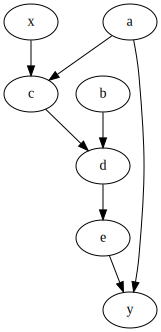

In [56]:
from graphviz import Digraph

digraph = Digraph()
nodes = ["a", "b", "x", "c", "d", "e", "y"]

for v in nodes:
    digraph.node(v, v)

digraph.edges(["ac", "xc", "cd", "bd", "de", "ay", "ey"])

digraph

To compute $ \frac{dy}{da} $, we employ the chain rule, telling us that

$$
\frac{dy}{da} = \frac{dy}{dc} \frac{\partial c}{\partial a} + \frac{dy}{dy}\frac{\partial y}{\partial a}.
$$

In other words, $ \frac{dy}{dc} $ must be computed before $ \frac{dy}{da} $. Here, a correct reverse topological ordering would be `[y, e, d, b, c, a, x]`.

How to find the reversed topological ordering of our computational graphs? You know, the ones that are defined via the `Scalar` objects. Here's a possible implementation.

In [57]:
class Scalar(Scalar):   
    # ...

    def _get_graph(self):
        ordered_scalars = []
        visited_scalars = set()

        def traverse_graph(x):
            if x not in visited_scalars:
                visited_scalars.add(x)

                for prev, _ in x.prevs:
                    traverse_graph(prev)

                ordered_scalars.append(x)

        traverse_graph(self)

        return ordered_scalars
    
    # ...

In English, the `Scalar._get_graph` method recursively travels the computational graph. Check out the `traverse_graph` function that is called for each node: it appends the input node to the `ordered_scalars` list only when all of its parents are traversed. This way, the topological order is preserved; thus, `ordered_scalars` contains a topologically ordered list of all `Scalar` nodes.

So, here's our (not so) pseudo-backpropagation:

```
for v in reversed(y._get_graph()):
    v._backward_step()
```

(Where `y` is the terminal node of our graph, and `reversed` is a built-in tool of Python that reverses iterators.)

Let's not waste any more time and implement this right away!

### Completing the backward pass

We are almost done; in fact, we have all the pieces ready. Let's combine the `Scalar._backward_step` and `Scalar._get_graph` methods together in the `Scalar.backward`.

(One small modification to `_get_graph`: we add an option to zero out the backward derivatives. This is needed to make sure our computations don't overflow into the subsequent passes.)

In [58]:
class Scalar(Scalar):
    # ...

    def _backward_step(self):
        for prev, local_grad in self.prevs:
            prev.backwards_grad += local_grad * self.backwards_grad

    def _get_graph(self, zero_grad=False):
        ordered_scalars = []
        visited_scalars = set()

        def traverse_graph(x):
            if x not in visited_scalars:
                visited_scalars.add(x)

                if zero_grad:
                    x.backwards_grad = 0

                for prev, _ in x.prevs:
                    traverse_graph(prev)

                ordered_scalars.append(x)

        traverse_graph(self)

        return ordered_scalars

    def backward(self):
        ordered_scalars = self._get_graph(zero_grad=True)

        self.backwards_grad = 1

        for scalar in reversed(ordered_scalars):
            scalar._backward_step()

    # ...

The `Scalar.backwards` method does as what we stated in our pseudoalgorithm, with setting the backwards gradient to one. (Recall that the default value of `Scalar.backwards_grad` is `0`, but the global derivative of a node with respect to itself is `1`.)

## Backpropagation in action

We've finally implemented backpropagation, the soul of computational graphs. It's time to see it in practice.

Let's stick with the simplest possible example: a linear model, for instance, $ y = 2 x - 1 $. It's easy to see that $ \frac{dy}{dx} = 2 $, so let's check if that's indeed the case.

In [59]:
a = Scalar(2)
b = Scalar(-1)


def linear(x: Scalar):
    return a*x + b

In [60]:
x = Scalar(42)
y = linear(x)

In [61]:
y.backward()

`Scalar.backward` runs without error, so we're halfway there. What are the results?

In [62]:
y.backwards_grad

1

In [63]:
x.backwards_grad

2

Just as we expected! Let's check if it works for other inputs.

In [64]:
import numpy as np


xs = [Scalar(x) for x  in np.linspace(-10, 10, 1000)]
dydxs = [x.backwards_grad for x in xs if linear(x).backward() or 1]

In [65]:
np.all([dydx == 2 for dydx in dydxs])

np.True_

Awesome! Let's move on to a harder example.

### Verifying backpropagation

Now that we have all our ducks in a row, let's use a more complex computational graph to check if our implementation indeed works. Moving on from linear models, we'll use the previously seen `sigmoid(a * x + b) + a`.

The `Scalar` interface have changed quite a lot since {ref}`the last time we implemented functions <section:computational-graphs/forward-pass/functions>`, so let's revisit the sigmoid. Here's the vanilla version.

In [66]:
def _sigmoid(x):
    return 1/(1 + np.exp(-x))

def _sigmoid_prime(x):
    return _sigmoid(x) * (1 - _sigmoid(x))

Let's scalarize this.

In [67]:
def sigmoid(x: Scalar) -> Scalar:
    return Scalar(
        value=_sigmoid(x.value),
        prevs=[Edge(x, _sigmoid_prime(x.value))]
    )

Now, we are ready for `sigmoid(a * x + b) + a`.

In [68]:
a = Scalar(2)
b = Scalar(-1)

def f(x):
    return sigmoid(a * x + b) + a

You can verify by hand that the derivative of $ f $ is

$$
\begin{align*}
\frac{df}{dx} &= a \sigma^\prime(a x + b) \\
&= a \sigma(ax + b) \big(1 + \sigma(ax + b) \big),
\end{align*}
$$

so let's plot this side-by-side with the result of backpropagation.

In [69]:
def f_prime(x):
    return a.value * _sigmoid_prime(a.value * x + b.value)

In [70]:
xs_np = np.linspace(-5, 5, 1000)
xs = [Scalar(x) for x  in xs_np]

dydxs = [x.backwards_grad for x in xs if f(x).backward() or 1]
dydxs_np = f_prime(xs_np)

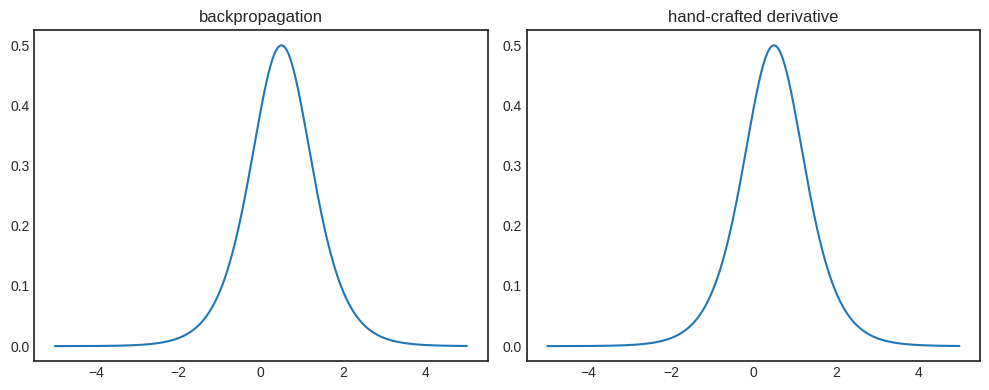

In [71]:
import matplotlib.pyplot as plt


with plt.style.context("seaborn-v0_8-white"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(xs_np, dydxs)
    axs[0].set_title('backpropagation')

    axs[1].plot(xs_np, dydxs_np)
    axs[1].set_title('hand-crafted derivative')

    plt.tight_layout()
    plt.show()

We happy, Vincent? We happy.

There's only one thing missing from `Scalar`. We've gone quite a long way, but we still haven't trained any model. Let's see how it's done in the next chapter!